#                                                                Title: Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/) — a great piece of data journalism that's totally worth reading.

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis

## Importing Libraries

In [134]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
plt.style.use('fivethirtyeight')

## Creating Support Functions

In [69]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        return display(df)

## Exploring the Data

In [70]:
past_rat = pd.read_csv("fandango_score_comparison.csv")
new_rat = pd.read_csv("movie_ratings_16_17.csv")

In [71]:
display_all(past_rat.head(2))

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5


In [72]:
display_all(new_rat.head(2))

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.8,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.4,3.65,2.5,4.15,2.5,3.5,2.5,4.0


We notice that there are several columns in both datasets that correspond to specific values for fandango.
 - First we will isolate the following columns from past_rat ["FILM", "Fandango_Stars", "Fandango_Ratingvalue", "Fandango_voters", "Fandango_Difference"]
 - Second we will isolte the following columns from new_rat [ 'movie', 'year', 'fandango']

In [73]:
fandango_old = past_rat[["FILM", "Fandango_Stars", "Fandango_Ratingvalue","Fandango_votes", "Fandango_Difference"]]
fandango_new = new_rat[['movie', 'year', 'fandango']]

In [74]:
fandango_old.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [75]:
print(fandango_old.shape)

(146, 5)


In [76]:
fandango_new.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


In [77]:
print(fandango_new.shape)

(214, 3)


Our aim is to see whether the difference in ratings of fandango movies changed over time.

## Step 1: Sampling
To start of our analysis we are going to are going to extract a few random samples and understand the sampling_error from all populations (past_rat, fandango_old,  new_rat and fandango_new)

From Hickey's article and from the [README.md](https://github.com/fivethirtyeight/data/tree/master/fandango) of the data set's repository, we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

Let's try to run 100 iteration on the old raitings, without setting any major constraint to see how the static and the paramter deviate.

In [78]:
def sample_mean(series):
    mean_list = []
    for i in range(100):
        sample_mean = series.sample(10, random_state = i).mean()
        mean_list.append(sample_mean)
    return mean_list

In [79]:
lst = sample_mean(fandango_old["Fandango_Ratingvalue"])
print(lst[0:5])

[3.75, 3.900000000000001, 3.9900000000000007, 3.7800000000000002, 3.8]


In [80]:
def sample_error(mean_list, series):
    parameter = series.mean()
    sample_err_lst = []
    for i in range(100):
        sample_err = parameter - mean_list[i]
        sample_err_lst.append(sample_err)
    return sample_err_lst

In [81]:
sample_err = sample_error(lst,fandango_old["Fandango_Ratingvalue"])
print(sample_err[0:5])

[0.09520547945204827, -0.05479452054795253, -0.1447945205479524, 0.06520547945204802, 0.04520547945204845]


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


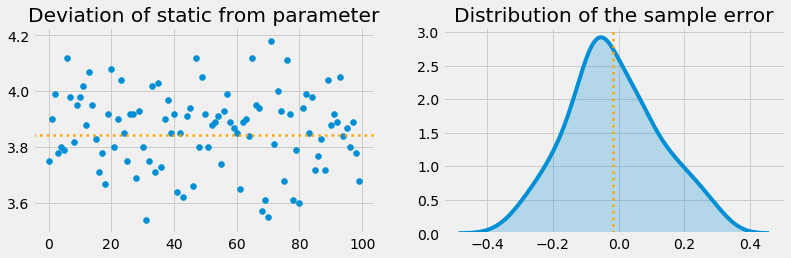

In [100]:
fig = plt.figure(figsize = (12, 12))

plt.subplot(321)
plt.scatter( y = lst, x = range(0,100))
plt.title("Deviation of static from parameter")
plt.axhline(fandango_old["Fandango_Ratingvalue"].mean(), color = "orange", linestyle = "dotted", linewidth = 2.5)
plt.subplot(322)
sns.kdeplot(sample_err, shade = True)
plt.axvline(sum(sample_err)/len(sample_err), color = "orange", linestyle = "dotted", linewidth = 2.5)
plt.title("Distribution of the sample error")

plt.show()

We notice that more or less that all the samples (except for a few outliers) have a sample error of +-0.2. This suggests that most of the sample are representative of the actual population as their mean rating value is similar.

## Step 2: Changing the Goal of our Analysis
Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

We define popular movies as movies that have at least more than the mean user_votes. But first we check that the distribution is not strongly skewed as this could cause our threshold to be wrong

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


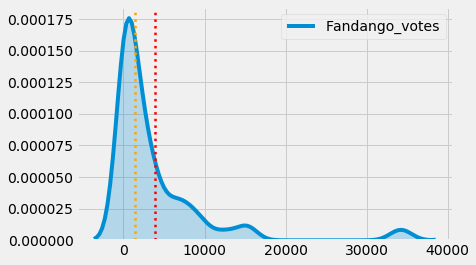

In [83]:
sns.kdeplot(fandango_old["Fandango_votes"], shade = True)
plt.axvline(fandango_old["Fandango_votes"].mean(), color = "red", linestyle = "dotted" ,linewidth = 2.5)
plt.axvline(fandango_old["Fandango_votes"].median(), color = "orange", linestyle = "dotted", linewidth = 2.5)

Indeed, we notice that the distribution has a strong postive skew nevertheless we also notice that the mean is higher than the median. This suggests that few values in the "Fandango_votes" column are higher than the rest. 
On the basis, of the following rationale we concluded that not the mean but the median of "Fandango_votes" will be a good aproximator for popular movies.

With the new goal, we now have two populations that we want to describe and compare with each other:
- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.


Nevertheless, we encounter two main problems:
- There are movies that have a date which is neither 2015 nor 2016.
- The new fandango_raitings do not have any column that is representative of the votes.

We adopted the following two solutions to this problem.
1. Because we want to only see the difference between the date in which the article has been released (2015) and the imidiate future (2016) we isolte all the columns that have a date above or below these two values.
2. We will source the current votes on fandango's website for our current sample. Still this does not tell us if the movie is popular. Nevertheless due to this limitation we have to set a threshold of **50 votes** to define a popular movie, instead of using the median of each population.

## Step 3: Extracting a Representative Sample

#### Sample 2015 fandango raitings

Because our population has changed we also need to change our sampling conditions accordingly:
- Let's run 100 sample iteration and set a threshold for our sample error. This time the population will be either every movie that has been released in 2015 or everymovie that has been released in 2016

In [104]:
fandango_old.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,release_year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


We notice that the Year is embeded as a string in the FILM column. We proceed with extracting it.

In [105]:
fandango_old["release_year"] = fandango_old["FILM"].str[-5:-1]
fandango_old.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,release_year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [106]:
fandango_old.shape

(146, 6)

Next, we set take out only the movies that have been released in the 2015 and that have more than 50 votes.

In [144]:
boolean = ["2015"]
fandango_2015 = fandango_old[(fandango_old["release_year"].isin(boolean)) & (fandango_old["Fandango_votes"] > 50)]
fandango_2015["release_year"].value_counts()

2015    117
Name: release_year, dtype: int64

Now that we have our new population we can run 100 sampling iterations to understand the distribution of the sampling error.

In [108]:
lst_2015 = sample_mean(fandango_2015["Fandango_Ratingvalue"])
print(lst_2015[0:5])

[3.66, 4.06, 3.8599999999999994, 3.8600000000000003, 3.9199999999999995]


In [109]:
sample_err_2015 = sample_error(lst_2015,fandango_2015["Fandango_Ratingvalue"])
print(sample_err_2015[0:5])

[0.20239316239315608, -0.1976068376068434, 0.002393162393156789, 0.002393162393155901, -0.057606837606843264]


Let's now plot the results to get a better understanding.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


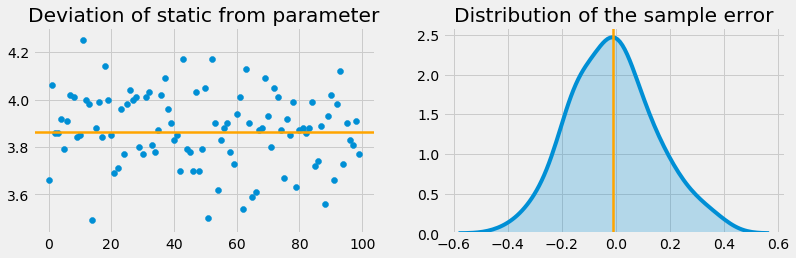

In [110]:
fig = plt.figure(figsize = (12, 12))

plt.subplot(321)
plt.scatter(y = lst_2015, x = range(0,100))
plt.axhline(fandango_2015["Fandango_Ratingvalue"].mean(), color = "orange",  linewidth = 2.5)
plt.title("Deviation of static from parameter")
plt.subplot(322)
sns.kdeplot(sample_err_2015, shade = True)
plt.axvline(sum(sample_err_2015)/len(sample_err_2015), color = "orange", linewidth = 2.5)
plt.title("Distribution of the sample error")

plt.show()

As shown by the graph the sample error is quiet various and the best way for us to select a representative sample is by either increasing the size of the sample to 20 or by setting a sample which is near to the mean sample error (0.01). 

We decided to go for the second option and set a threshold of equal to 50% the distibution of the sample error. The threshold for our sample to be representative is 0.1

We now extract a sample form our dataframe

In [111]:
sample_2015 = fandango_2015.sample(10, random_state = 1)

Let's see whether our sample is representative by computing the sample error.

In [112]:
sample_error_2015 = fandango_2015["Fandango_Ratingvalue"].mean() - sample_2015["Fandango_Ratingvalue"].mean()
print(sample_error_2015)

-0.1976068376068434


We notice that the sample error is outside of the parameters we dictated earlier, hence we proceed with extracting another sample.

In [113]:
sample_2015 = fandango_2015.sample(10, random_state = 2)
sample_error_2015 = fandango_2015["Fandango_Ratingvalue"].mean() - sample_2015["Fandango_Ratingvalue"].mean()
print(sample_error_2015)

0.002393162393156789


This time the sample error is 0.002, which is within the threshold that we set earlier. Thus, we conclude that it is representative of the population.

#### Sample 2016 fandango raitings

In [114]:
fandango_new.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


As we discussed earlier there is no trace of the acutal votes these movies have received hence we have to first draw a sample and then manually check whether the votes of each movie are more than 50.

We also have to take out all the movies that have been released after 2016.

Let us first proceed with this step

In [115]:
fandango_2016  = fandango_new[fandango_new["year"] == 2016]
fandango_2016["year"].value_counts()

2016    191
Name: year, dtype: int64

Now we extract the sample and asses whether the sample error is in line with our threshold. But because this is a new population we need to set a new threshold.

In [116]:
lst_2016 = sample_mean(fandango_2016["fandango"])
print(lst_2016[0:5])

[3.9, 3.95, 4.15, 3.8, 3.85]


In [117]:
sample_err_2016 = sample_error(lst_2016,fandango_2016["fandango"])
print(sample_err_2016[0:5])

[-0.012565445026178068, -0.06256544502617833, -0.2625654450261785, 0.08743455497382202, 0.037434554973821754]


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


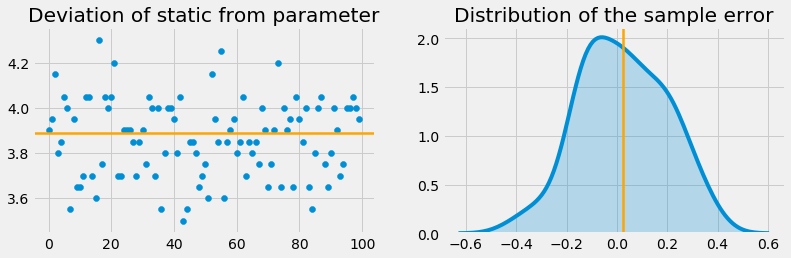

In [118]:
fig = plt.figure(figsize = (12, 12))

plt.subplot(321)
plt.scatter(y = lst_2016, x = range(0,100))
plt.axhline(fandango_2016["fandango"].mean(), color = "orange",  linewidth = 2.5)
plt.title("Deviation of static from parameter")
plt.subplot(322)
sns.kdeplot(sample_err_2016, shade = True)
plt.axvline(sum(sample_err_2016)/len(sample_err_2016), color = "orange", linewidth = 2.5)
plt.title("Distribution of the sample error")

plt.show()

As for the 2015 fandango raitings, for 2016 we also set a threshold of +-0.1

In [119]:
sample_2016 = fandango_2016.sample(10, random_state = 1)

Let's see whether our sample is representative

In [120]:
sample_error_2016 = fandango_2016["fandango"].mean() - sample_2016["fandango"].mean()
print(sample_error_2016)

-0.06256544502617833


We the sample error is -0.06. Thus, we conclude that the sample is representative of the population.

Now we have to validate our second claim that these are all popular movies. Let's first have a look at what movies are in our current sample.

In [64]:
sample_2016

,movie,year,fandango
36,Collide,2016,3.5
75,Ice Age: Collision Course,2016,4.0
125,Now You See Me 2,2016,4.0
171,The Disappointments Room,2016,2.5
92,Kubo and the Two Strings,2016,4.5
134,Pride and Prejudice and Zombies,2016,4.0
40,Deadpool,2016,4.5
115,Money Monster,2016,4.0
204,War Dogs,2016,4.0
111,Miracles from Heaven,2016,4.5


After sourcing each movie online we found the following vote_count for each movie:

In [67]:
vote_count = [335,2242,6215,383,4008,1818,44739,4086, 3473,4840]
sample_2016["vote_count"] = vote_count
sample_2016

,movie,year,fandango,vote_count
36,Collide,2016,3.5,335
75,Ice Age: Collision Course,2016,4.0,2242
125,Now You See Me 2,2016,4.0,6215
171,The Disappointments Room,2016,2.5,383
92,Kubo and the Two Strings,2016,4.5,4008
134,Pride and Prejudice and Zombies,2016,4.0,1818
40,Deadpool,2016,4.5,44739
115,Money Monster,2016,4.0,4086
204,War Dogs,2016,4.0,3473
111,Miracles from Heaven,2016,4.5,4840


All the movies exeed the 50 vote threshold by far and hence can be defined as popular.

## Step 4: Comparing the shapes of the two years (2015, 2016)
We now have the possibility of doing a multiple comparison first we can compare the movie ratings from our 2015 and our 2016 population. We can also weighten the rankings by the total votes each movies has received and compare the two sample we extracted from our populations.

#### Populations - KeyDensityPlot

Let us first compare the raitings distribution for our population of 2015 and 2016. After we are going to dig a bit deeper into the samples.

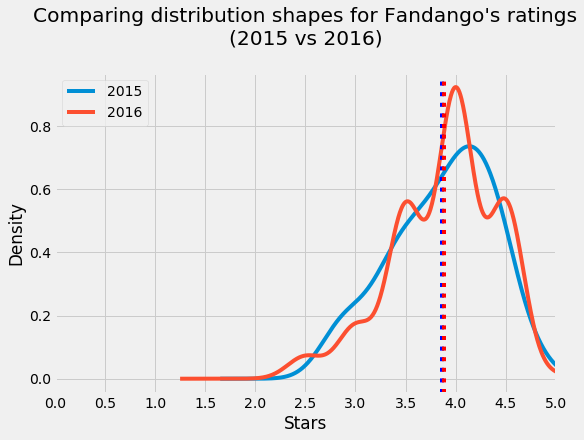

In [153]:
fandango_2015["Fandango_Ratingvalue"].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)


plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.axvline(fandango_2015['Fandango_Ratingvalue'].mean(), color ="blue", linestyle = "dotted")
plt.axvline(fandango_2016['fandango'].mean(), color ="red", linestyle = "dotted")
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(np.arange(0,5.1,.5))
plt.legend()
plt.show()

We notice that the distribution of the two is not equal. Nevertheless, it does not seem that there is a major change in the rating difference between the two populations.

Indeed, the graph also shows that both distribution posses a nearly equal mean.

Let us now explore the summary statistics for both popoulations an see if we notice some major difference:

#### Population - Summary Statistics

In [165]:
desc = fandango_2016["fandango"].describe() 
df = pd.DataFrame(desc)
df.rename(columns={"fandango": "2016"},inplace = True)
df["2015"] = fandango_2015["Fandango_Ratingvalue"].describe()
df

,2016,2015
count,191.000000,117.000000
mean,3.887435,3.862393
std,0.509540,0.510363
min,2.500000,2.700000
25%,3.500000,3.500000
50%,4.000000,3.900000
75%,4.250000,4.300000
max,5.000000,4.800000


In [169]:
diff = df["2016"][0]-df["2015"][0]
diff

74.0

We notice straight away that there is a major difference in entries between the two populations. The population of 2016 has 74 more entries. This renders any comparison in between the two movie meaningless. Indeed, we cannot quanitfy the impact that 74 newly added ratings can have on the current distribution of _fandango_2015_.

Hence, we have to use the two samples we extracted earlier and compare their distribution.

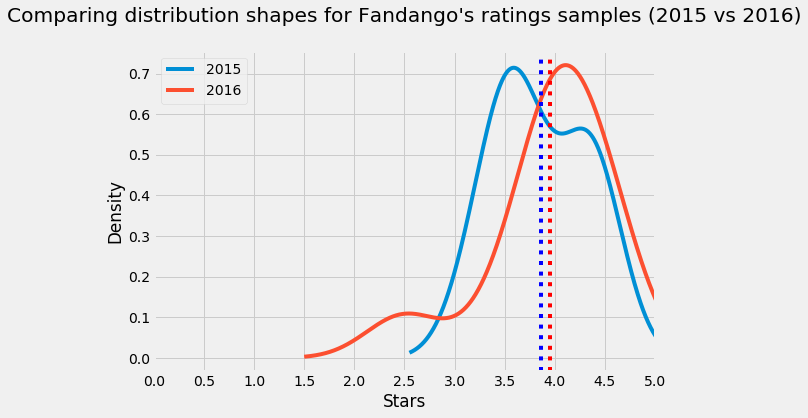

In [173]:
sample_2015["Fandango_Ratingvalue"].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
sample_2016['fandango'].plot.kde(label = '2016', legend = True)


plt.title("Comparing distribution shapes for Fandango's ratings samples (2015 vs 2016)",
          y = 1.07) # the `y` parameter pads the title upward
plt.axvline(sample_2015['Fandango_Ratingvalue'].mean(), color ="blue", linestyle = "dotted")
plt.axvline(sample_2016['fandango'].mean(), color ="red", linestyle = "dotted")
plt.xlabel('Stars')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(np.arange(0,5.1,.5))
plt.legend()
plt.show()

We notice that 2015 has a lower key population density and its distribution is more positivley skewed. This is not in line with what we expected.

Let's plot the summary statistics and see whether we find something interesting.

In [175]:
desc = sample_2016["fandango"].describe() 
df = pd.DataFrame(desc)
df.rename(columns={"fandango": "2016"},inplace = True)
df["2015"] = sample_2015["Fandango_Ratingvalue"].describe()
df

,2016,2015
count,10.000000,10.000000
mean,3.950000,3.860000
std,0.598609,0.455095
min,2.500000,3.200000
25%,4.000000,3.600000
50%,4.000000,3.700000
75%,4.375000,4.275000
max,4.500000,4.500000


## Step 5 - Conclusion Summary:
While the median is the same for both distributions (in both instances - the median is the same). Nevertheless, the mean is lower in 2015. Coupled with what we saw for the mean and the median, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2015 were rated slightly lower than popular movies released in 2016. 

This is not what we expected when we first started our reserach. Still, given the poor difference in mean and the equality of the median we cannot draw major inferences. Indeed, claming that Fandango raitings have gone up would be a biased conclusion.

Our analysis ONLY showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2015 were rated slightly lower on Fandango than popular movies released in 2016.